# Connect neo4j

In [1]:
#connect neo4j with RNeo4j
library(RNeo4j)

graph = startGraph("http://localhost:7474/db/data/", username="neo4j", password="xiaowei")

# Get all gene names in GREG

## Make a function to get all gene names.

In [2]:
#----------------------------------------------------------------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------
#--------------------#获取所有基因
#----------------------------------------------------------------------
#---建一个函数来获取数据库里面所有gene names
#该基因gene name 存在于 node的Details属性上
#返回数据框，包含基因名称，节点的id号和节点label， 节点Name

getAllGeneName = function(){
  #连接neo4j数据库
  
  library(RNeo4j)
  graph = startGraph("http://localhost:7474/db/data/", username="neo4j", password="xiaowei")
  
  #cypher语言查询
  query = "
        //get all nodes which had `Details` property
        //查找有Details属性的节点
      MATCH (n)
      where exists(n.Details)

        //split the Details information
        //利用split函数拆分Details属性值
      with split(n.Details, ';') AS Details,id(n) AS NodeID, labels(n) AS NodeLabel, n.Name AS NodeNames

        //change the list format
        //利用UNWIND将Details列表换成表格形式
      UNWIND Details AS details
      with details, NodeID, NodeLabel, NodeNames

        //filter those Details information which includes gene_name
        // 筛选出含有gene_name的信息
      where details contains 'gene_name'
      with details as genes, NodeID, NodeLabel, NodeNames

        // use `substring` to get real gene names
        // 然后利用substring函数截取基因名称， 返回基因名称，节点的id号和节点label
      return substring(genes,11) as geneName, NodeID, NodeLabel, NodeNames
  "
  #进行查询
  allGenes <- RNeo4j::cypher(graph, query) 
  
  #返回查询结果
  return(allGenes)
}

Your code contains a unicode char which cannot be displayed in your
current locale and R will silently convert it to an escaped form when the
R kernel executes this code. This can lead to subtle errors if you use
such chars to do comparisons. For more information, please see
https://github.com/IRkernel/repr/wiki/Problems-with-unicode-on-windows

## a data frame of  all gene in chromosome

In [3]:
#-----------all gene in chromosome---------------------
AllgeneName <- getAllGeneName()

In [4]:
AllgeneName <- unique(AllgeneName)

In [5]:
head(AllgeneName)

geneName,NodeID,NodeLabel,NodeNames
<chr>,<int>,<chr>,<chr>
DDX11L1,0,chr1,Bin1
WASH7P,0,chr1,Bin1
MIR6859-1,0,chr1,Bin1
RP11-34P13.3,0,chr1,Bin1
MIR1302-2,0,chr1,Bin1
FAM138A,0,chr1,Bin1


In [24]:
dim(AllgeneName)

[1] 67300     4

GREG have 67418 genes names. 

## a data frame of  all TF 

In [6]:
#-----------TF----------------------
query = "MATCH (n:TF)
        RETURN n.Name AS geneName, id(n) AS NodeID, labels(n) AS NodeLabel, n.Name AS NodeNames"
TFName =unique( cypher(graph, query) )

In [7]:
head(TFName)
dim(TFName)

geneName,NodeID,NodeLabel,NodeNames
<chr>,<int>,<chr>,<chr>
AFF4,15448,TF,AFF4
AHR,15449,TF,AHR
ARID3A,15450,TF,ARID3A
ARNT,15451,TF,ARNT
ARRB1,15452,TF,ARRB1
ATF1,15453,TF,ATF1


[1] 261   4

## a data frame of  LncRNA 

In [8]:
#-----------LncRNA----------------
query = "MATCH (n:LncRNA)
        RETURN n.Name AS geneName, id(n) AS NodeID, labels(n) AS NodeLabel, n.Name AS NodeNames"
LncRNAName = unique( cypher(graph, query) )


In [9]:
head(LncRNAName)
dim(LncRNAName)

geneName,NodeID,NodeLabel,NodeNames
<chr>,<int>,<chr>,<chr>
ANRASSF1,1288086,LncRNA,ANRASSF1
C5-AS1,1288087,LncRNA,C5-AS1
lincRNA-p21,1288088,LncRNA,lincRNA-p21
SRA,1288089,LncRNA,SRA
CAT7,1288090,LncRNA,CAT7
ANRIL,1288091,LncRNA,ANRIL


[1] 35  4

## a data frame of  all gene names and TF and LncRNA

In [10]:
#------------AllgeneName_TF_LncRNA--------------------------------------
AllgeneName_TF_LncRNA = unique( rbind(TFName, LncRNAName, AllgeneName) )
#AllgeneName_TF_LncRNA就是整个数据库里面所有的基因名称和TF以及LncRNA

Your code contains a unicode char which cannot be displayed in your
current locale and R will silently convert it to an escaped form when the
R kernel executes this code. This can lead to subtle errors if you use
such chars to do comparisons. For more information, please see
https://github.com/IRkernel/repr/wiki/Problems-with-unicode-on-windows

In [11]:
head(AllgeneName_TF_LncRNA)
dim(AllgeneName_TF_LncRNA)

geneName,NodeID,NodeLabel,NodeNames
<chr>,<int>,<chr>,<chr>
AFF4,15448,TF,AFF4
AHR,15449,TF,AHR
ARID3A,15450,TF,ARID3A
ARNT,15451,TF,ARNT
ARRB1,15452,TF,ARRB1
ATF1,15453,TF,ATF1


[1] 67596     4

In [12]:
dim(unique(AllgeneName_TF_LncRNA))

[1] 67596     4

# a function `geneMatchIndex` for find out those nodes that genes we want

The format of geneMatchIndex is:

`geneMatchIndex(gene, allGeneNode, FullMatch = 1, by = "geneName")`

>**`gene`：** a vector, what genes you want to match.  
>
>**`allGeneNode`:**  `allGeneNode` is data you chose which one as your match. It must is one of `AllgeneName_TF_LncRNA`, `TFName`, `LncRNAName` and `AllgeneName`.  
>
>**`FullMatch = 1`** : This is as defaults. please set argument `FullMatch = 0` ,if you want use fuzzy match for those gene names contain strings of your input. 
>
>**`by`** : one type of  `"geneName"`,  `"NodeID"`,   ` "NodeLabel"` and  `"NodeNames"`, it should be as your genes types.

**Results**

A list contains `TargetNodes` and `NoGeneIndex`.

`TargetNodes` is a frame data of those matched in `allGeneNode`. `NoGeneIndex` is a vector included those didnot find out in `allGeneNode`. 

In [13]:
#----------------------------------------------------------------------------------------------------------------------
#这是一个函数，用来匹配一个list的节点对应的id，基因名称等等

#-----------grep或者which---------------------
#-----------------------------------------
#a function geneMatchIndex for find out those nodes that genes we want
#一个函数用来查找gene在所有基因数据框内的对应位置和没有匹配的基因

# allGeneNode is you chose which one as your match. It must is one of AllgeneName_TF_LncRNA, TFName, LncRNAName and AllgeneName.

#This is as defaults. please set argument `FullMatch = 0` If you want use fuzzy match for those gene names contain strings of your input.
#FullMatch默认为1，也就是说默认使用的是完全匹配的方式，找到的基因名称跟输入的是一模一样的
#FullMatch如果是其他数字，则用grep的方式查找含有该字符串的基因位置

#Result is a list includes a data frame of `TargetNodes` about genes and a vector `NoGeneIndex` about those genes not in GREG.
#返回的是两个向量的list，geneIndex是对应基因的位置；NoGeneIndex是该基因在数据库中没有找到

#The argument `by` must one of `"geneName"`,  `"NodeID"` ,   `"NodeLabel"` and `"NodeNames"`. It means the type of your input data.
#第三个参数是指匹配的是哪个类型， 是属于基因名，还是节点id，节点的label和节点名称
#第三个参数 即 "geneName"  "NodeID"    "NodeLabel" "NodeNames"

geneMatchIndex = function(gene, allGeneNode, FullMatch = 1, by = "geneName"){
  geneIndex = c() 
  NoGeneIndex =  c()
  Ag = allGeneNode[by]
  if (FullMatch == 1){
    #----------which-----------------
    for (i in 1:length(gene) ) {
      geneIndex1 = which(Ag == gene[i] )
      if (length(geneIndex1) == 0){NoGeneIndex = c(gene[i], NoGeneIndex)}
      else{geneIndex = c(geneIndex,geneIndex1)}
    }
  }
  
  else{
    #----------grep---------------
    for (i in 1:length(gene) ) {
      geneIndex1 = grep(gene[i],Ag, fixed = TRUE)
      if (length(geneIndex1) == 0){NoGeneIndex = c(gene[i], NoGeneIndex)}
      else{geneIndex = c(geneIndex,geneIndex1)}
    }
  }
  
  TargetNodes <- allGeneNode[geneIndex, ]
  geneInGREG = list(TargetNodes, NoGeneIndex)
  names(geneInGREG) = c("TargetNodes", "NoGeneIndex")
  #返回匹配上的TargetNodes和没有找到基因NoGeneIndex
  return (geneInGREG )
}


#--------------geneMatchIndex函数说明--------------------------------------------------------------------------------------------------------
#geneMatchIndex(gene, allGeneNode, FullMatch = 1, by = "geneName")
#gene：你自己选择基因列表，可以使基因对应的节点id，也可以是基因名称，还可以是基因对应节点的Name属性。
#allGeneNode #It must is one of AllgeneName_TF_LncRNA, TFName, LncRNAName and AllgeneName.
#FullMatch = 1， 直接匹配；
#by: 选择对应的类型 "geneName"  "NodeID"    "NodeLabel" "NodeNames"

#返回匹配上的TargetNodes和没有找到基因NoGeneIndex
#----------------------------------------------------------------------------------------------------------------------

Your code contains a unicode char which cannot be displayed in your
current locale and R will silently convert it to an escaped form when the
R kernel executes this code. This can lead to subtle errors if you use
such chars to do comparisons. For more information, please see
https://github.com/IRkernel/repr/wiki/Problems-with-unicode-on-windows

# Use cypher command to make modules for chr12


## Make modules for chr12

In [14]:
query = "
// to make louvain modules for chr12
CALL algo.louvain.stream(
  'MATCH (n:chr12)--(m) with id(n) as chr12,id(m) AS m   MATCH (al) where id(al) = m or  id(al) = chr12 with distinct al As al return id(al) as id',
  'MATCH (n:chr12)-[r]-(m) RETURN id(n) AS source, id(m) AS target',
  {graph:'cypher',direction: 'both'})
YIELD nodeId, community

MATCH (n)
where id(n) = nodeId

with collect (id(n)) AS AllnodeId, 'module'+community AS community, collect(n.Name) AS AllNodeNames
RETURN AllnodeId, community, AllNodeNames, size(AllnodeId) AS size_of_allnode
"

In [15]:
mod1 = cypher(graph, query)

In [16]:
class(mod1)
names(mod1)

[1] "data.frame"

[1] "AllnodeId"       "community"       "AllNodeNames"    "size_of_allnode"

`AllnodeId` just is columns of nodes ids in each module. 

`community` is columns  of modules names.

`AllNodeNames` is columns for all nodes those have `Name` properties.

`size_of_allnode` is calculated by `AllnodeId`.

## How many modules(communities) in mod1?

In [17]:
nrow(mod1)

[1] 50

# Get all gene names/chr12 names/ TF names in each modules

In [18]:
mod2 <- mod1

#mod1_match_gene to save all match results.
mod1_match_gene <- list() #用来存放每个模块nodeid匹配后对应的gene列表，里面包括
for (i in 1:nrow(mod2)){
  Mod_nodeId_list = unlist(mod1$AllnodeId[i])
  Mod_nodes_list = geneMatchIndex(Mod_nodeId_list, AllgeneName_TF_LncRNA, FullMatch = 1, by = "NodeID")
  Mod_gene_nodes_list = unique(Mod_nodes_list$TargetNodes) #得到每个模块nodeID匹配后基因的列表,加上一个unique来避免重复
  
  mod1_match_gene[[i]] <-  Mod_gene_nodes_list #保存匹配后的结果
  
  #Get all gene , TF and LncRNA names in each modules
  mod2$allGeneTFLncRNA[[i]] <- unique(Mod_gene_nodes_list$geneName) #得到每个模块对应的基因数量，加上一个unique来避免重复
  mod2$size_of_allGeneTFLncRNA[i] <- length(mod2$allGeneTFLncRNA[[i]])  #统计每个匹配后基因的数量
  
  #Get all chr12 names in each modules
  mod2$allchr12Name[[i]] <- unique(Mod_gene_nodes_list$NodeNames[which(Mod_gene_nodes_list$NodeLabel == 'chr12')]) #获取每个模块里chr12的节点名称,加上一个unique来避免重复
  mod2$size_of_allchr12Name[i] <- length(mod2$allchr12Name[[i]]) #统计每个模块匹配后chr12节点的数量
  
  #Get all TF names in each modules
  mod2$AllTF[[i]] <- unique(Mod_gene_nodes_list$NodeNames[which(Mod_gene_nodes_list$NodeLabel == 'TF')]) ##获取每个模块里TF的节点名称,加上一个unique来避免重复
  mod2$size_of_AllTF[i] <- length(mod2$AllTF[[i]]) #统计每个模块匹配后TF节点的数量
}
names(mod1_match_gene) <- mod2$community

Your code contains a unicode char which cannot be displayed in your
current locale and R will silently convert it to an escaped form when the
R kernel executes this code. This can lead to subtle errors if you use
such chars to do comparisons. For more information, please see
https://github.com/IRkernel/repr/wiki/Problems-with-unicode-on-windows

In [19]:
names(mod2)

[1] "AllnodeId"               "community"              
 [3] "AllNodeNames"            "size_of_allnode"        
 [5] "allGeneTFLncRNA"         "size_of_allGeneTFLncRNA"
 [7] "allchr12Name"            "size_of_allchr12Name"   
 [9] "AllTF"                   "size_of_AllTF"

In [20]:
#mod2[1,]

# numbers of genes / chr12 node / all node in each community(module)

In [21]:
#---define the backgroup of plot
library(ggplot2)
backgroup <-   theme(axis.text.x = element_text(vjust = 0.5, hjust = 1, angle = 90 ),
                     plot.title = element_text(face ="bold" ,hjust = 0.5),
                     panel.grid.major = element_blank(), #删除网格线
                     panel.grid.minor = element_blank(), #删除网格线
                     panel.background=element_rect(fill='transparent',color ="gray"))

Your code contains a unicode char which cannot be displayed in your
current locale and R will silently convert it to an escaped form when the
R kernel executes this code. This can lead to subtle errors if you use
such chars to do comparisons. For more information, please see
https://github.com/IRkernel/repr/wiki/Problems-with-unicode-on-windowsRegistered S3 method overwritten by 'grid':
  method     from  
  print.path RNeo4j


We chose data in the top 10 of `size_of_allGeneTFLncRNA` to plot.

Your code contains a unicode char which cannot be displayed in your
current locale and R will silently convert it to an escaped form when the
R kernel executes this code. This can lead to subtle errors if you use
such chars to do comparisons. For more information, please see
https://github.com/IRkernel/repr/wiki/Problems-with-unicode-on-windows

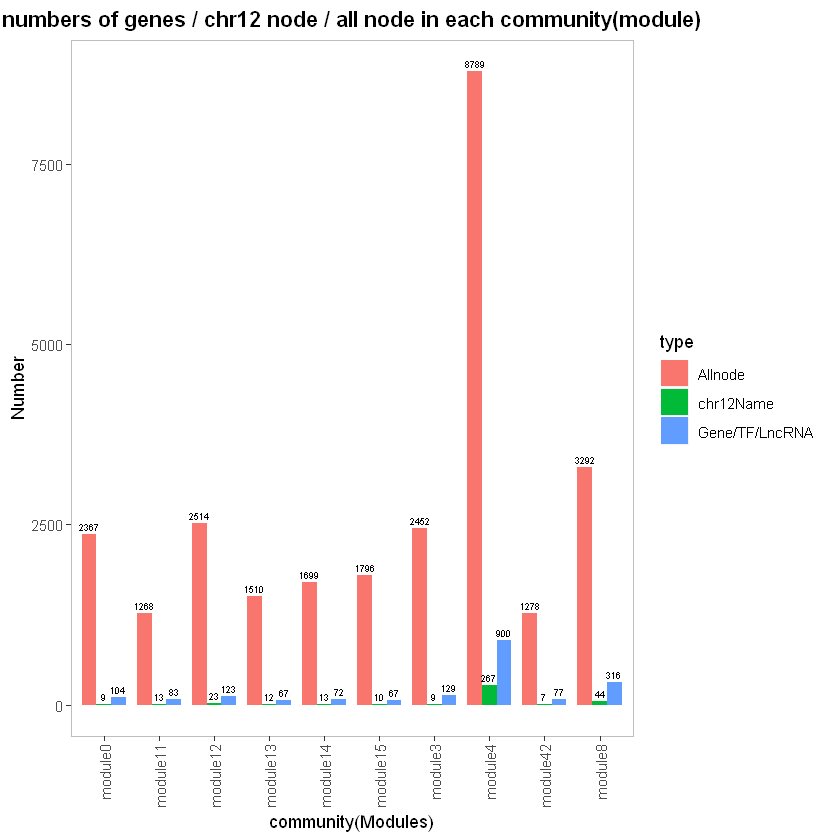

In [22]:
mod2 <- mod2[order(-mod2[,'size_of_allGeneTFLncRNA']),]
number_gene = mod2[,c('community','size_of_allGeneTFLncRNA')][1:10,]
number_gene$type = rep('Gene/TF/LncRNA', nrow(number_gene))
names(number_gene)[2] = 'count' 

number_chr12node = mod2[,c('community','size_of_allchr12Name')][1:10,]
number_chr12node$type = rep('chr12Name', nrow(number_chr12node))
names(number_chr12node)[2] = 'count'

number_AllNode = mod2[,c('community','size_of_allnode')][1:10,]
number_AllNode$type = rep('Allnode', nrow(number_AllNode))
names(number_AllNode)[2] = 'count'

number_gene_chr12node_AllNode = rbind(number_gene,number_chr12node,number_AllNode)

library(ggplot2)
ggplot(number_gene_chr12node_AllNode, aes(x = community, y = count,fill = type)) +
  geom_bar(stat="identity", position = 'dodge',width=0.8)+  ##identity意味着把y当做值去输入，如果改成bin，就会计算y出现的频数。dodge意味是各组是左右分布而不是上下重叠
  labs(x="community(Modules)",y = "Number")+
  ggtitle("numbers of genes / chr12 node / all node in each community(module)", ) + backgroup+
  geom_text(aes(x = number_gene_chr12node_AllNode$community, 
                y = number_gene_chr12node_AllNode$count,
                group = number_gene_chr12node_AllNode$type, 
                label=number_gene_chr12node_AllNode$count), position=position_dodge(0.8),hjust=0.5, size = 2, vjust = -0.5)

In [24]:
save(AllgeneName,TFName,LncRNAName,AllgeneName_TF_LncRNA, mod1,mod2, file = "moduleForchr12.RData")